In [103]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA

from utils import *

## Encode Cifar-5

In [3]:
data_cifar = np.loadtxt("data/cifar-5/data.txt")
labels_cifar = np.loadtxt("data/cifar-5/labels.txt")
classes = np.unique(labels_cifar)
data_cifar.shape, labels_cifar.shape, classes.shape

((2500, 4224), (2500,), (5,))

In [47]:
cluster_per_class = 2
kmeans = KMeans(n_clusters=int(len(classes)*cluster_per_class), n_jobs=-1, verbose=1).fit(data_cifar)
# kmeans = KMeans(n_clusters=6, n_jobs=-1, verbose=1).fit(data_cifar)

In [48]:
kmeans.cluster_centers_.shape, kmeans.labels_.shape, np.unique(kmeans.labels_).shape

((10, 4224), (2500,), (10,))

(array([496., 500., 154., 314., 371., 128.,   5., 186., 165., 181.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

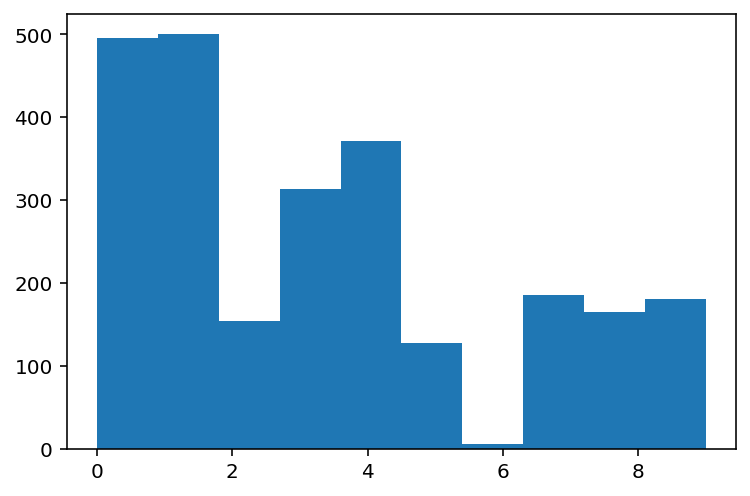

In [49]:
plt.hist(kmeans.labels_, bins=np.unique(kmeans.labels_).shape[0])

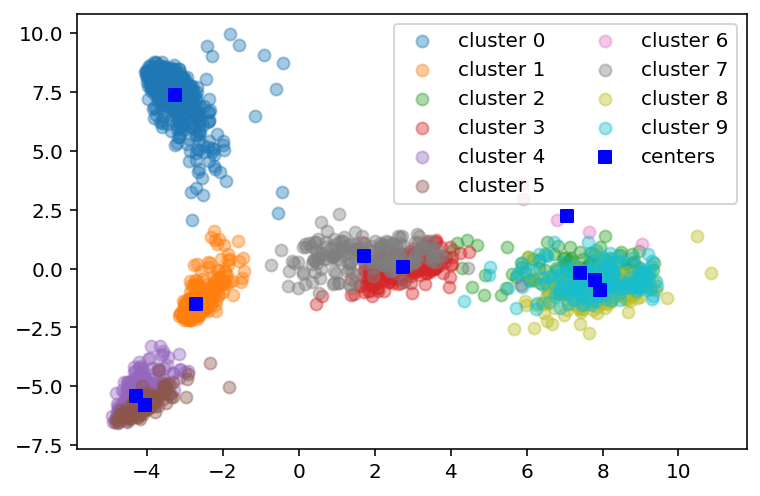

In [50]:
%config InlineBackend.figure_format = 'retina'
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_cifar)
centers = pca.transform(kmeans.cluster_centers_)

for label in np.unique(kmeans.labels_):
    mask = (kmeans.labels_ == label)
    plt.scatter(data_pca[mask, 0], data_pca[mask, 1], alpha=0.4, label="cluster " + str(int(label)))
plt.scatter(centers[:, 0], centers[:, 1], marker='s', label='centers', c='b')
plt.legend(ncol=2)

In [56]:
threshold = 10
cluster_cnts = np.histogram(kmeans.labels_, bins=len(np.unique(kmeans.labels_)))[0]

cluster_remain = np.where(cluster_cnts > 10)
center_remain = kmeans.cluster_centers_[cluster_cnts > 10]

In [66]:
elim_labels = np.where(cluster_cnts <= 10)
data_cifar[kmeans.labels_ == elim_labels[0], :].shape
(data_cifar[kmeans.labels_ == elim_labels[0], :] - center_remain).shape
# labels_remain = kmeans.labels_.copy()
# labels_remain[]

ValueError: operands could not be broadcast together with shapes (5,4224) (9,4224) 

In [69]:
kmeans.cluster_centers_ = kmeans.cluster_centers_[cluster_remain]

In [72]:
kmeans.labels_[kmeans.labels_ == elim_labels[0]] = kmeans.predict(data_cifar[kmeans.labels_ == elim_labels[0], :])

In [77]:
kmeans.labels_.shape, labels_cifar.shape

((2500,), (2500,))

## Subclass Exploring 5-Class

In [246]:
data_cifar = np.loadtxt('data/cifar-5/encoding.txt')
subclasses_cifar, idx, freq = np.unique(data_cifar[:, :], axis=0, return_counts=True, return_index=True)
subclasses_cifar.shape, freq, idx

((8, 2),
 array([  1,   4, 500, 500, 496, 499, 300, 200], dtype=int64),
 array([ 892, 1247, 2000,    0, 1000,  500, 1500, 1502], dtype=int64))

The 892-th sample and 1247-th sample should be mistakenly classified in VGGNet for Cifar-100.

In [104]:
data = np.loadtxt('data/encoding_merged.txt')
data.shape

(2500, 3)

In [323]:
subclasses, freq = np.unique(list(data[:, :]), axis=0, return_counts=True)
subclasses.shape, freq

((48, 3),
 array([ 18,  45,  49,  51,  21,  11,  40,  86, 125, 137,  67,  55,   5,
         10,   3,   6,   3,   7,  84, 206, 184, 110,   1,   1,   1,  44,
         32,  20,   8,  27,  28,  41,  43, 273,  62,  14,  11,   1,   2,
          5,  60,  79,  97, 157,   1,   1,  96,  72], dtype=int64))

[0. 1. 2. 3. 4.]


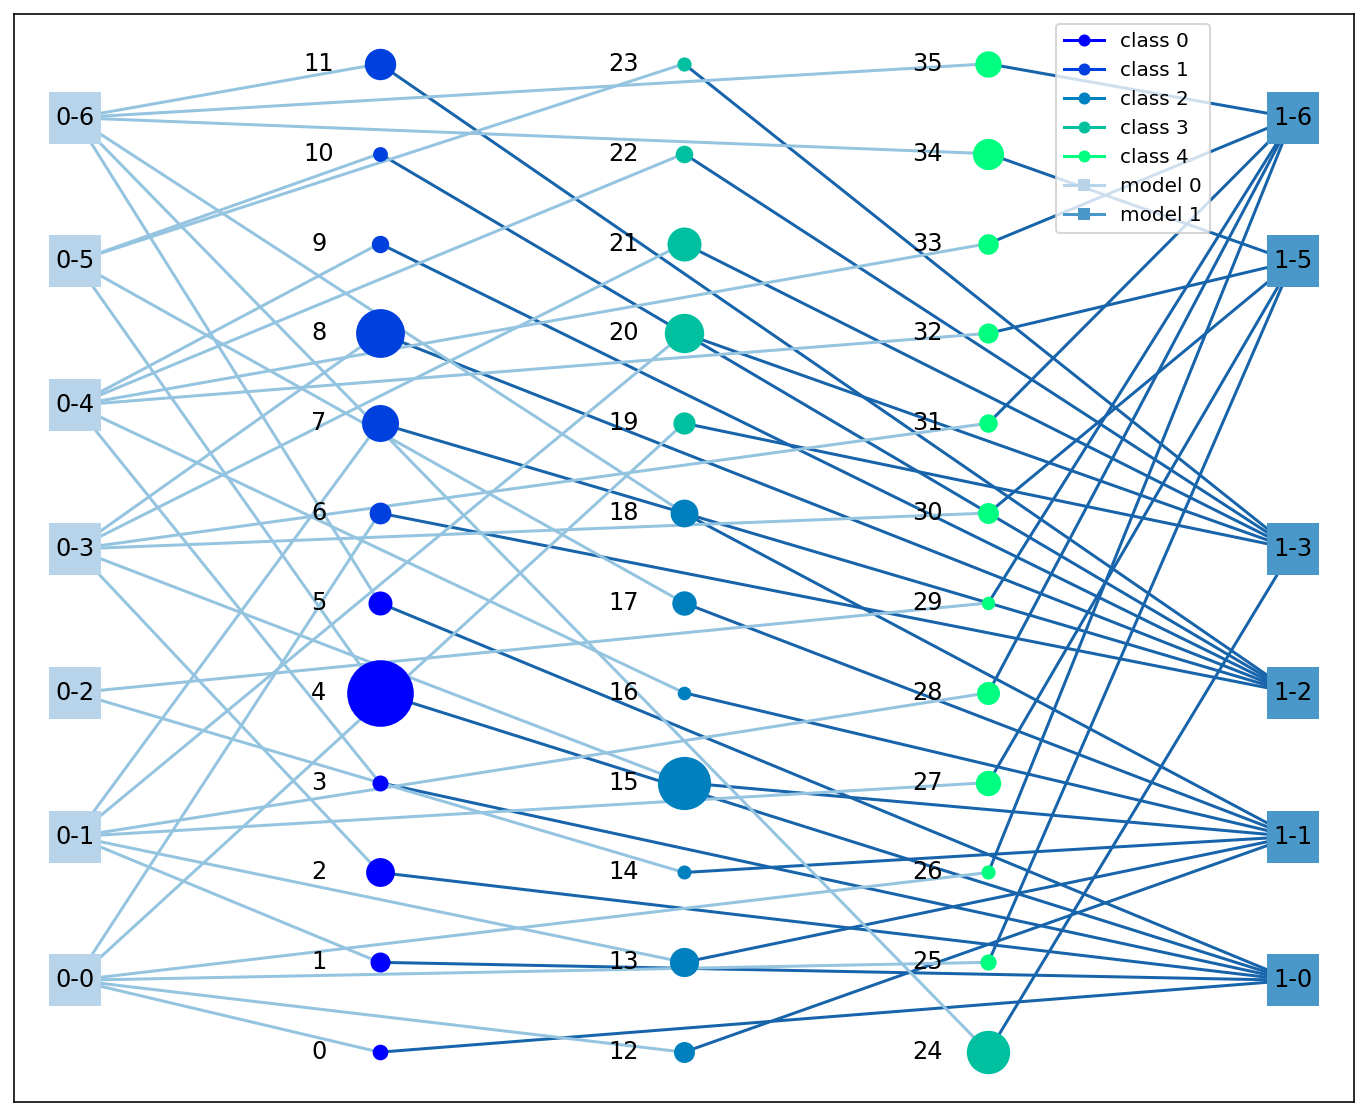

In [357]:
def plot_network_venn(data, subclasses, cluster_sets, ncol):
    count = lambda x: sum((data[:, 0] == x[0]) & (data[:, 1] == x[1]))
    per_col = np.ceil(subclasses.shape[0] / ncol)
    labels = subclasses[:, -1]
    subclasses = subclasses[:, :-1]
    stride = 15 * 0.5 / per_col
    markers = dict()
    cluster_markers = dict()
    
    G = nx.Graph()
    cl_pos = dict()
    cmap = ['b', 'g']
    for i, subclass in enumerate(subclasses):
        for j, cl in enumerate(subclass):
            plt.plot([1+1*(i // per_col), j*4], [stride*(i % per_col)-0.5, cl*1], c=plt.cm.Blues(j*0.4+0.4))
    for i, subclass in enumerate(subclasses):
        G.add_node(i, encoding=subclass, size=count(subclass)*5+200, shape='skyblue', pos=(1+1*(i // per_col)-0.2, stride*(i % per_col)-0.5))
        markers[int(labels[i])], = plt.plot(1+1*(i // per_col), stride*(i % per_col)-0.5, marker='o', ms=5, c=plt.cm.winter(labels[i]/labels.max()))
        plt.plot(1+1*(i // per_col), stride*(i % per_col)-0.5, marker='o', ms=count(subclass)/10+5, c=plt.cm.winter (labels[i]/labels.max()))
    for i, clusters in enumerate(cluster_sets):
        for cl in clusters:
            G.add_node('{:.0f}-{:.0f}'.format(i, cl), encoding=None, size=500, shape='orangered', pos=(i*4, cl*1))
            cluster_markers[i], = plt.plot(i*4, cl*1, ms=5, marker='s', c=plt.cm.Blues(i*0.3+0.3))
            plt.plot(i*4, cl*1, ms=25, marker='s', c=plt.cm.Blues(i*0.3+0.3))
    
    nx.draw_networkx(G, node_size=0, pos=G.nodes(data='pos'))
    lines = list(markers.values()) + list(cluster_markers.values())
    labels = ['class {}'.format(label) for label in markers.keys()] + ['model {}'.format(label) for label in cluster_markers.keys()]
    plt.legend(lines, labels, loc=1, ncol=1, bbox_to_anchor=(0.9, 1))

plt.figure(figsize=[12, 10])
tmp = subclasses[freq > 6]
print(np.unique(tmp[:, -1]))
tmp = np.array(sorted(list(tmp), key=lambda x: x[-1]))
plot_network_venn(data, tmp, [np.unique(tmp[:, i]) for i in range(tmp.shape[1]-1)], 3)